## Study of the 2D flow around a NACA wing shape

In [1]:
import lettuce as lt
import torch
import numpy as np
from scipy import interpolate
from matplotlib import pyplot as plt
from time import time

In [17]:
Ma = 0.1                   ## The speed of streaming
n_stream = 10              ## air should have passed the wing length n_stream-times

### APPLICATION ###
# turbine_diameter =
wing_length = 1             ## 'depth' of airfoil profile
tempC = 10                  ## degrees celcius
#p = 14.5                   ## air pressure
rho = 1.293                 ## kg/m³ air density
vchar = 5                   ## usually medium streaming velocity (may also be maximum velocity, around 1.5-times)
                            ## large wind turbines produce maximum power at 15 m/s. This can be assumed to be streaming velocity around the centre
dt_pu = 1e-5                ## this should allow up to 25,000 Hz

### DOMAIN ###
nx = 600                   ## number of lattice nodes in x-direction
ny = 150                    ## number of lattice nodes in y-direction
nz = 20
# shape = (nx, ny)            ## domain shape
x_wing_nose = 1             ## physical space before wing
x_wing_tail = 3             ## physical space behind wing
chord_length = wing_length  ## physical length of wing
domain_length_x = x_wing_nose + wing_length + x_wing_tail
dx = domain_length_x/nx     ## i.e. resolution
n_wing_nose = int(x_wing_nose//dx)  ## first grid point with wing
n_wing_tail = int(x_wing_tail//dx)  ## first grid point with wing

### FLOW CHARACTERISTICS ###
#Re = 5e6
lchar = wing_length         ## characteristic length in pu is obstacle length
temp = tempC+273.15         ## temperature in Kelvin
visc_dyn = 2.791e-7*temp**0.7355 ## dynamic viscosity of air
visc_kin = visc_dyn/rho     ## kinematic viscosity of air
Re = vchar*lchar/visc_kin   ## The type of streaming around the foil. Small (1.5m) 8e3,medium (3-5m) 2e5, large (>5m-150m) up to 5e6

# number of steps depends on Mach number and resolution (?)
#nmax = 100000
t_max = wing_length/vchar*n_stream   ## simulate tmax-seconds

### SIMULATION PARAMETERS ##
# how often to report (every n simulation steps)
nreport = 100
# how often to print (every n simulation steps)
nconsole = 200
# how often to plot (every n console steps)
nplot = 1
# test for convergence and crash
test_iterations = True
test_convergence = False
epsilon = 1e-7
# run pre-simulation with low Re to get rid of initialization pulses
Re_pre = 1000
n_pre = 2000  # wing profiles with camber may crash at low Re

wing_dict = {
    'NACA-63215-highAOA',
    'NACA-63215-lowAOA',
    'NACA-63215-noAOA',
    'NACA-0012-lowAOA',
    'NACA-0012-noAOA'
}
re_dict = {
    1e3,
    1e4,
    1e5,
    1e6,
    1e7
}
res_dict = {
    100,
    200,
    300,
    400,
    500,
    600
}

### LETTUCE PARAMETERS ###
lattice = lt.Lattice(lt.D3Q27, torch.device("cuda:0"), use_native=False)


In [18]:
def mask_from_csv(x, y, wing_name):
    mask_shape = np.shape(x)
    nx1, ny1, nz1 = mask_shape
    dx = domain_length_x/nx1     ## i.e. resolution
    n_wing_nose = int(x_wing_nose//dx)  ## first grid point with wing
    n_wing_tail = int(x_wing_tail//dx)  ## first grid point with wing
    #n_wing_nose = int(nx1//5)    # wing starts after 1/5 of domain length
    #n_wing_tail = int(nx1*3//5)  # wing goes until 3/5 of domain length
    n_wing_height = int(ny1//2)  # wing sits at middle of domain length

    # read wing data from http://airfoiltools.com/plotter/index
    surface_data = np.genfromtxt(wing_name+'.csv', delimiter=",")[9:,:]
    surface_data = surface_data[:np.min(np.where(np.isnan(surface_data)[:,1])),:]
    zero_row = np.where(surface_data[:,0]==0)[0][0]
    x_data_top, y_data_top = surface_data[:zero_row,:].transpose()
    x_data_bottom, y_data_bottom = surface_data[zero_row:,:].transpose()

    # calculate scaling factor
    #x_wing_nose = x[n_wing_nose,0]
    #x_wing_tail = x[n_wing_tail,0]
    #available_length_x = x_wing_tail - x_wing_nose
    available_length_n = n_wing_tail-n_wing_nose
    actual_wing_length_x = max(max(x_data_top), max(x_data_bottom))
    scaling_factor = wing_length / actual_wing_length_x

    # scale wing data to fit domain restrictions
    x_data_top *= scaling_factor
    x_data_bottom *= scaling_factor
    y_data_top *= scaling_factor
    y_data_bottom *= scaling_factor

    # mapping data to the grid
    x_data_interp        = np.linspace(0, wing_length, available_length_n)            # [0 ... 5.05]
    y_data_top_interp2d  = np.array([interpolate.interp1d(x_data_top, y_data_top, fill_value="extrapolate")(x_data_interp)]).transpose()
    # y_data_top_interp3d  = np.resize(y_data_top_interp2d, (nx1, ny1, nz1))  # .interp1d object
    y_data_bottom_interp2d = np.array([interpolate.interp1d(x_data_bottom, y_data_bottom, fill_value="extrapolate")(x_data_interp)]).transpose()
    # y_data_bottom_interp3d = np.resize(y_data_bottom_interp2d, (nx1, ny1, nz1)) # .interp1d object

    # shifting the wing up by half the grid
    y_wing_height = y[0, n_wing_height, 0]
    y_data_top_interp2d += y_wing_height
    y_data_bottom_interp2d += y_wing_height

    # setting y data in a 2D grid to compare with flow.grid[1]
    y_data_top_mapped = np.zeros(mask_shape)
    y_data_bottom_mapped = np.zeros(mask_shape)
    for iz in range(nz1):
        y_data_top_mapped[n_wing_nose:n_wing_tail, :, iz] += y_data_top_interp2d
        y_data_bottom_mapped[n_wing_nose:n_wing_tail, :, iz] += y_data_bottom_interp2d

    # creating mask
    bool_mask = (y < y_data_top_mapped) & (y > y_data_bottom_mapped)
    return bool_mask

In [19]:
class Naca(lt.Obstacle):
    def __init__(self, wing_name, re_number, shape):
        super(Naca, self).__init__(shape, reynolds_number=re_number, mach_number=Ma,lattice=lattice,domain_length_x=domain_length_x,char_length=chord_length,char_velocity=vchar)
        x, y, z = self.grid
        self.mask = mask_from_csv(x, y, wing_name)

In [26]:
def setup_simulation(wing_name, file_name=None, tmax=t_max, re_number=Re, n_x=nx, n_y=ny, n_z=nz):
    if file_name is None:
        filename_base = r"/media/philipp/Storage/data/"+wing_name
    else:
        filename_base = r"/media/philipp/Storage/data/"+file_name
    shape = (n_x, n_y, n_z)
    print('shape = ', shape)
    flow = Naca(wing_name, re_number, shape)
    simulation = lt.Simulation(flow, lattice, lt.KBCCollision3D(lattice, flow.units.relaxation_parameter_lu),
                        lt.StandardStreaming(lattice))
    nmax = flow.units.convert_time_to_lu(tmax)
    print("Doing up to ", "{:.2e}".format(nmax), " steps.")
    print("Key paramters: run name:", file_name, ", chord length", chord_length, "[m], Re", "{:.2e}".format(re_number), "[1]")
    print("I will record every", nreport, "-th step, print every", nconsole, "-th step, and plot every", nconsole*nplot, "-th step.\n",
          "1000 steps correspond to", tmax/nmax*1e3, "seconds.\n")

    # set up reporters
    Energy = lt.IncompressibleKineticEnergy(lattice, flow)
    #energy_reporter_internal = lt.ObservableReporter(Energy, interval=nreport, out=None)
    #simulation.reporters.append(energy_reporter_internal)
    simulation.reporters.append(lt.ObservableReporter(Energy, interval=nconsole)) # print energy
    simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=nreport, filename_base=filename_base))
    return simulation, flow, Energy, nmax

def plot_u(flow, simulation, lattice):
    u = flow.units.convert_velocity_to_pu(lattice.u(simulation.f).detach().cpu().numpy())
    plt.imshow(u[0,:,:,int(nz//2)].T, origin="lower")
    plt.show()
    return

def run_n_plot(simulation, flow, Energy, nmax):
    # initialize simulation
    simulation.initialize_f_neq()
    if test_iterations:
        energy_new = 0
        mlups = 0
        iterations = int(nmax//nconsole)
        for i in range(iterations):
            mlups += simulation.step(nconsole)
            energy_old = energy_new
            energy_new = Energy(simulation.f).mean().item()
            rchange = abs((energy_new - energy_old)/energy_new)
            print("avg MLUPS: ", mlups/(i+1))
            if test_convergence and rchange < epsilon:
                print("CONVERGENCE! Less than ", epsilon*100, " % relative change")
                break
            elif test_convergence:
                print("no convergence, still ", round(rchange*100,5), " % relative change")
            elif not energy_new == energy_new:
                print("CRASHED!")
                break
            if i%nplot == 0:
                plot_u(flow, simulation, lattice)
        plot_u(flow, simulation, lattice)
    else:
        mlups = simulation.step(nmax)
        print("MLUPS: ", mlups)
        plot_u(flow, simulation, lattice)
    return

In [27]:
# Re -> vchar -> nmax

setup = {}
# do comparison of resolution
for ny in [100]:
    name = 'NACA-0012-lowAOA'
    run_name = name+'_ny'+str(ny)+'_3d'
    setup[run_name] = setup_simulation(name, run_name, tmax=wing_length/vchar*n_stream, re_number=Re, n_x=4*ny, n_y=ny)
# do comparison of wings and reynolds numbers
# for name in wing_dict:
#     for Re in re_dict:
#         vchar = Re*visc_kin/lchar
#         run_name = name+'_Re'+"{:.2e}".format(Re)
#         setup[run_name] = setup_simulation(name, run_name, tmax=wing_length/vchar*n_stream, re_number=Re)

shape =  (400, 100, 100)
Doing up to  1.39e+04  steps.
Key paramters: run name: NACA-0012-lowAOA_ny100_3d , chord length 1 [m], Re 3.64e+05 [1]
I will record every 100 -th step, print every 200 -th step, and plot every 200 -th step.
 1000 steps correspond to 0.1443375672974065 seconds.

steps     time     IncompressibleKineticEnergy


0 0.0 0.0
200 0.028867513459481294 11.142555236816406
avg MLUPS:  25.2598151690037


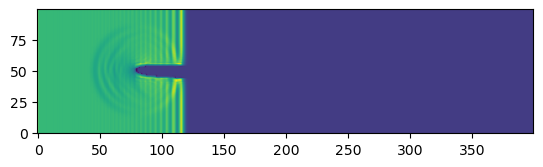

400 0.05773502691896259 22.373672485351562
avg MLUPS:  26.043375703785397


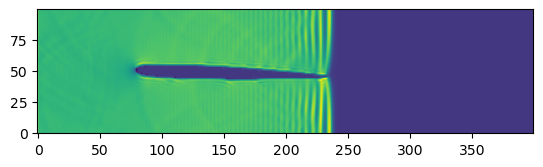

600 0.08660254037844389 35.08169937133789
avg MLUPS:  26.014910012895513


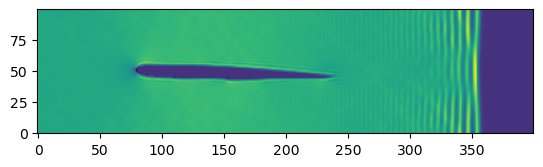

800 0.11547005383792518 58.6180419921875
avg MLUPS:  26.279128230931377


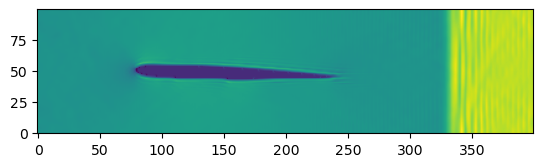

1000 0.1443375672974065 88.73612213134766
avg MLUPS:  26.57609842120729


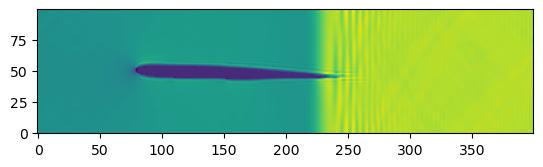

1200 0.17320508075688779 117.58428192138672
avg MLUPS:  26.795019433940652


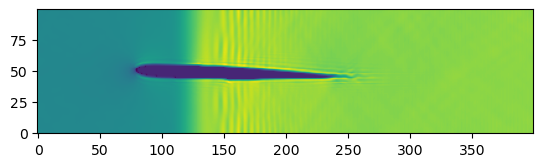

1400 0.20207259421636908 146.6754913330078
avg MLUPS:  26.92183130738136


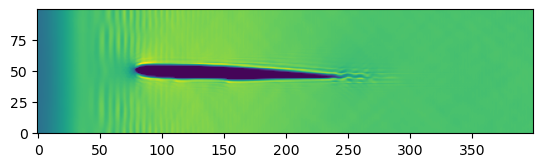

1600 0.23094010767585035 144.80450439453125
avg MLUPS:  26.909034717842655


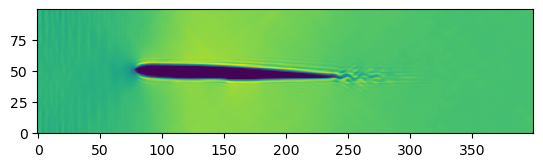

KeyboardInterrupt: 

In [28]:
for run_name in setup:
    t = time()
    [sim, flo, Ener, n_max] = setup[run_name]
    run_n_plot(sim, flo, Ener, n_max)
    print(run_name, " took ", time()-t, " s\n")